Lo primero que debemos hacer es filtar todos los datos que necesitamos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from ecgdetectors import Detectors
import neurokit2 as nk
import scipy.stats as stats
import seaborn as sns

datos = pd.read_excel(r'C:\Users\ctama\OneDrive\Desktop\Bioseñales\Proyecto\Datos\Diagnostics.xlsx')
copydatos= datos

In [2]:
AFIB = datos[datos["Rhythm"] == 'AFIB']
SB = datos[datos["Rhythm"] == 'SB']
SR = datos[datos["Rhythm"] == 'SR']
ST = datos[datos["Rhythm"] == 'ST']
AF = datos[datos["Rhythm"] == 'AF']
SA = datos[datos["Rhythm"] == 'SA']
SVT = datos[datos["Rhythm"] == 'SVT']
AT = datos[datos["Rhythm"] == 'AT']


El primer paso es limpiar todos los valores outliers, haremos dos pasadas y comprobaremos haciendo la grafica de boxplot

In [3]:
def filtrar_outliers(df):
    df_filtrado = pd.DataFrame()
    for tipo in df['Rhythm'].unique():
        subset = df[df['Rhythm'] == tipo]
        Q1 = subset['PatientAge'].quantile(0.25)
        Q3 = subset['PatientAge'].quantile(0.75)
        IQR = Q3 - Q1
        # Filtrar valores dentro del rango aceptable
        filtro = (subset['PatientAge'] >= Q1 - 1.5 * IQR) & (subset['PatientAge'] <= Q3 + 1.5 * IQR)
        df_filtrado = pd.concat([df_filtrado, subset[filtro]], axis=0)
    return df_filtrado

The interquartile range is often used to find outliers in data. Outliers here are defined as observations that fall below Q1 − 1.5 IQR or above Q3 + 1.5 IQR. In a boxplot, the highest and lowest occurring value within this limit are indicated by whiskers of the box (frequently with an additional bar at the end of the whisker) and any outliers as individual points.

Referencia https://en.wikipedia.org/wiki/Interquartile_range

In [4]:
limpiav1= filtrar_outliers(copydatos)
limpiav2= filtrar_outliers(limpiav1)

C:\Users\ctama\AppData\Local\Temp\ipykernel_92520\2558886903.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=limpiav2, x='Rhythm', y='PatientAge', palette='pastel')


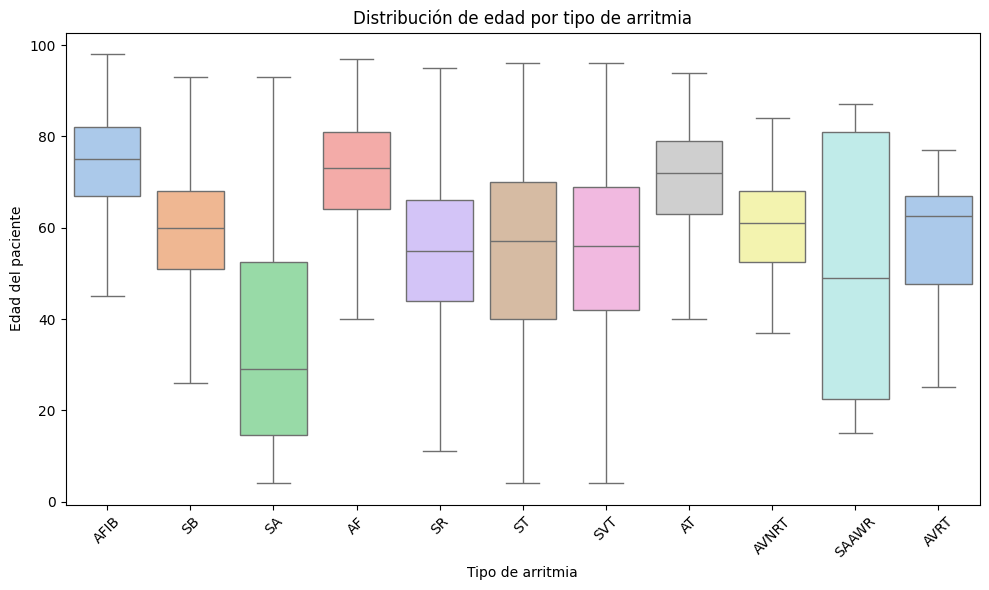

In [5]:
#3 Arritmias más prevalentes según edad

bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20', '21-40', '41-60', '61-80', '81-100']
limpiav2['AgeGroup'] = pd.cut(limpiav2['PatientAge'], bins=bins, labels=labels)

# Boxplot de edad por tipo de arritmia
plt.figure(figsize=(10, 6))
sns.boxplot(data=limpiav2, x='Rhythm', y='PatientAge', palette='pastel')
plt.title("Distribución de edad por tipo de arritmia")
plt.xlabel("Tipo de arritmia")
plt.ylabel("Edad del paciente")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Siguiendo las intrucciones del primer analisis, seleccionamos las arritmias y descartamos las demas, y aparte mantenemos el rango de edad entrer 20 y 80 años

In [6]:
arritmias_permitidas = ['SB', 'SR', 'ST', 'AFIB', 'SVT', 'AF', 'SA', 'AT']

# Filtrar el DataFrame
df_filtrado = limpiav2[
    (limpiav2['Rhythm'].isin(arritmias_permitidas)) &
    (limpiav2['PatientAge'] >= 20) &
    (limpiav2['PatientAge'] <= 80)
].copy()

In [7]:
df_filtrado

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset,AgeGroup
6,MUSE_20180114_075026_69000,AFIB,TWC,80,FEMALE,98,86,74,360,459,69,83,17,215,252,395,61-80
15,MUSE_20180113_133901_16000,AFIB,STTC,67,FEMALE,72,65,90,416,455,-1,-15,12,228,273,436,61-80
35,MUSE_20180113_074740_85000,AFIB,NONE,74,FEMALE,90,77,80,356,435,42,7,15,229,269,407,61-80
37,MUSE_20180114_132044_36000,AFIB,LVHV VPB,71,MALE,115,97,84,324,448,34,39,19,227,269,389,61-80
39,MUSE_20180116_131337_59000,AFIB,NONE,77,MALE,94,267,70,338,422,39,37,15,224,259,393,61-80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10257,MUSE_20180118_180414_04000,AT,APB IDC,60,FEMALE,137,315,104,336,507,22,43,22,214,266,382,41-60
10273,MUSE_20180119_174304_25000,AT,LVQRSCL,64,MALE,87,87,82,378,454,65,59,14,221,262,410,61-80
10274,MUSE_20180119_174306_34000,AT,LVQRSCL,64,MALE,91,110,88,344,423,56,37,15,220,264,392,61-80
10275,MUSE_20180119_174507_54000,AT,PWC,70,MALE,79,98,84,346,396,72,70,13,222,264,395,61-80


Trabajaremos con los datos de los dos generos, pero como se evidencio en el analisis 1, en ciertas arritmias existen mas cosas de un genero que el otro, se realiza un balanceo de datos, para evitar sesgos en el analisis.

In [8]:
def balancear_por_sexo_y_arritmia(df, columna_arritmia='Rhythm', columna_sexo='Gender'):
    df_balanceado = pd.DataFrame()

    for arritmia in df[columna_arritmia].unique():
        grupo = df[df[columna_arritmia] == arritmia]

        # Separar por sexo
        hombres = grupo[grupo[columna_sexo] == 'MALE']
        mujeres = grupo[grupo[columna_sexo] == 'FEMALE']

        # Determinar cuántos se pueden conservar (el mínimo entre ambos)
        n = min(len(hombres), len(mujeres))

        # Tomar muestra aleatoria estratificada (sin reemplazo)
        hombres_muestra = hombres.sample(n=n, random_state=42)
        mujeres_muestra = mujeres.sample(n=n, random_state=42)

        # Unir y añadir al DataFrame final
        df_balanceado = pd.concat([df_balanceado, hombres_muestra, mujeres_muestra], axis=0)

    return df_balanceado.reset_index(drop=True)

In [9]:
df_balanceado = balancear_por_sexo_y_arritmia(df_filtrado)
print(df_balanceado['Rhythm'].value_counts())
print(df_balanceado['Gender'].value_counts())

Rhythm
SB      2640
SR      1476
ST      1290
AFIB     992
SVT      488
AF       276
SA       236
AT        82
Name: count, dtype: int64
Gender
MALE      3740
FEMALE    3740
Name: count, dtype: int64


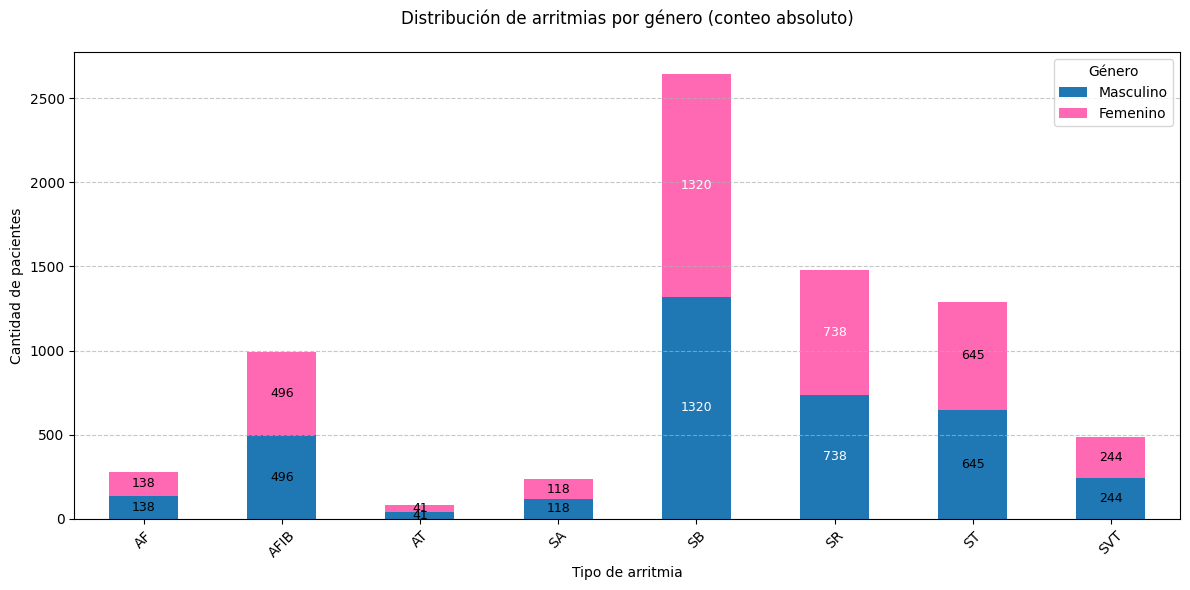

In [10]:
# Agrupar por tipo de arritmia y género
arrhythmia_by_gender = df_balanceado.groupby(['Rhythm', 'Gender']).size().unstack(fill_value=0)

# Reordenar columnas para que 'MALE' esté primero
arrhythmia_by_gender = arrhythmia_by_gender[['MALE', 'FEMALE']]

# Definir colores: azul para masculino, rosado para femenino
colors = ['#1f77b4', '#ff69b4']

# Crear gráfico de barras apiladas
ax = arrhythmia_by_gender.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

# Añadir etiquetas con los valores en cada segmento de barra
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    if height > 0:  # Solo mostrar etiquetas si hay valores
        x, y = p.get_xy() 
        ax.annotate(
            f'{int(height)}', 
            (x + width/2, y + height/2), 
            ha='center', 
            va='center',
            fontsize=9,
            color='white' if height > max(arrhythmia_by_gender.max())/2 else 'black'
        )

# Etiquetas y título
plt.title("Distribución de arritmias por género (conteo absoluto)", pad=20)
plt.xlabel("Tipo de arritmia")
plt.ylabel("Cantidad de pacientes")
plt.xticks(rotation=45)
plt.legend(title="Género", labels=["Masculino", "Femenino"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

for rhythm in arrhythmia_by_gender.index:
    total = arrhythmia_by_gender.loc[rhythm].sum()
    male_count = arrhythmia_by_gender.loc[rhythm, 'MALE']
    female_count = arrhythmia_by_gender.loc[rhythm, 'FEMALE']
    
    male_percent = (male_count / total) * 100
    female_percent = (female_count / total) * 100
    
    dominant = 'MASCULINO' if male_count > female_count else 'FEMENINO'
    dominance_ratio = max(male_count, female_count) / min(male_count, female_count) if min(male_count, female_count) > 0 else np.inf

Teniendo correctamente nuestros datos procesados, podemos empezar a calcular el pico R a cada arritmia

In [11]:
df_balanceado.columns

Index(['FileName', 'Rhythm', 'Beat', 'PatientAge', 'Gender', 'VentricularRate',
       'AtrialRate', 'QRSDuration', 'QTInterval', 'QTCorrected', 'RAxis',
       'TAxis', 'QRSCount', 'QOnset', 'QOffset', 'TOffset', 'AgeGroup'],
      dtype='object')

In [12]:
df_balanceado

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset,AgeGroup
0,MUSE_20180712_160452_75000,AFIB,LVH,74,MALE,49,57,92,488,440,64,70,7,221,267,465,61-80
1,MUSE_20180118_131905_87000,AFIB,TWC,72,MALE,151,170,84,298,472,-13,176,25,210,252,359,61-80
2,MUSE_20180114_071444_05000,AFIB,TWC,74,MALE,107,108,82,342,456,50,64,18,216,257,387,61-80
3,MUSE_20180114_132956_24000,AFIB,LVHV TWC,68,MALE,95,87,84,334,419,45,18,16,228,270,395,61-80
4,MUSE_20180118_124852_18000,AFIB,STTU,78,MALE,97,153,104,344,436,-29,29,16,221,273,393,61-80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7475,MUSE_20180114_124959_72000,AT,LVHV STDD,77,FEMALE,110,110,106,310,419,43,53,18,219,272,374,61-80
7476,MUSE_20180113_134050_13000,AT,NONE,79,FEMALE,109,109,72,350,471,22,-9,17,225,261,400,61-80
7477,MUSE_20180114_071212_35000,AT,2AVB STTC,75,FEMALE,143,156,74,328,506,56,-13,24,219,256,383,61-80
7478,MUSE_20180115_123937_31000,AT,NONE,63,FEMALE,99,99,76,348,446,53,43,16,225,263,399,61-80


In [16]:
df_balanceado.to_excel('DatosfiltradosconpicosR.xlsx', index=False, sheet_name='Datos')

In [ ]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt

# === Configuración ===
indice = 459  # Índice del archivo a procesar
nombre_archivo = df_balanceado['FileName'][indice]
frecuencia_muestreo = 500  # Hz

# === Cargar señal ECG ===
ruta = rf'C:\Users\ctama\OneDrive\Desktop\Bioseñales\Proyecto\Datos\ECGDataDenoised\ECGDataDenoised\{nombre_archivo}.csv'
senal = pd.read_csv(ruta, delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])

# Verificar columna II
if "II" not in senal.columns:
    raise ValueError("La columna 'II' no existe en el archivo.")

# Usar derivación II
ecg_signal = senal['II'].values

# === Procesar ECG (sin gráficos automáticos) ===
ecg_processed, info = nk.ecg_process(ecg_signal, sampling_rate=frecuencia_muestreo)
picos_r = info["ECG_R_Peaks"]

# === Calcular intervalos RR (necesarios para LF/HF con NumPy) ===
rr_intervals = np.diff(picos_r) / frecuencia_muestreo  # Convertir a segundos

# === Métricas HRV con NeuroKit2 ===
hrv_metrics = nk.hrv(picos_r, sampling_rate=frecuencia_muestreo, metrics=["sdnn", "rmssd", "lfhf"], show=False)
sdnn = hrv_metrics["HRV_SDNN"].values[0]
rmssd = hrv_metrics["HRV_RMSSD"].values[0]
lf_hf_nk = hrv_metrics["HRV_LFHF"].values[0]  # LF/HF de NeuroKit2

# === Cálculo de LF/HF con NumPy ===
# === 3. Calcular intervalos RR (en segundos) ===
rr_intervals = np.diff(picos_r) / frecuencia_muestreo  # Tiene N-1 elementos

# === Cálculo de LF/HF con NumPy ===
# 1. Tiempos acumulados de los picos R (sin el primer pico)
tiempos = np.cumsum(rr_intervals)  # Tiene N-1 elementos (como rr_intervals)

# 2. Interpolar (usar tiempos desde el primer intervalo RR en adelante)
tiempos_interp = np.linspace(tiempos[0], tiempos[-1], len(tiempos))
rr_interp = np.interp(tiempos_interp, tiempos, rr_intervals)  # ¡Ahora las longitudes coinciden!

# 3. Transformada de Fourier
frecuencias = np.fft.fftfreq(len(rr_interp), d=1/frecuencia_muestreo)
espectro = np.abs(np.fft.fft(rr_interp))**2

# 4. Bandas de frecuencia
lf_band = (frecuencias >= 0.04) & (frecuencias <= 0.15)
hf_band = (frecuencias >= 0.15) & (frecuencias <= 0.4)

potencia_lf = np.sum(espectro[lf_band])
potencia_hf = np.sum(espectro[hf_band])

# 5. LF/HF (evitar división por cero)
lf_hf_numpy = potencia_lf / potencia_hf if potencia_hf != 0 else np.nan

# === Resultados ===
print(f"\nArchivo procesado: {nombre_archivo}")
print(f"SDNN (NeuroKit2): {sdnn:.2f} ms")
print(f"RMSSD (NeuroKit2): {rmssd:.2f} ms")
print(f"LF/HF (NeuroKit2): {lf_hf_nk:.2f}")
print(f"LF/HF (NumPy): {lf_hf_numpy:.2f}")




Archivo procesado: MUSE_20180114_065656_99000
SDNN (NeuroKit2): 58.33 ms
RMSSD (NeuroKit2): 54.99 ms
LF/HF (NeuroKit2): nan
LF/HF (NumPy): nan


c:\Python312\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


In [14]:
df_balanceado.to_excel('DatosfiltradosconR.xlsx', index=False, sheet_name='Datos')

In [44]:
DatosFiltradosGrupo = pd.read_excel(r'C:\Users\ctama\OneDrive\Desktop\Bioseñales\Proyecto\Analisis 2\resumido.xlsx')

DatosFiltradosGrupo.head()

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset,AgeGroup
0,MUSE_20180712_160452_75000,AFIB,LVH,74,MALE,49,57,92,488,440,64,70,7,221,267,465,61-80
1,MUSE_20180118_131905_87000,AFIB,TWC,72,MALE,151,170,84,298,472,-13,176,25,210,252,359,61-80
2,MUSE_20180114_071444_05000,AFIB,TWC,74,MALE,107,108,82,342,456,50,64,18,216,257,387,61-80
3,MUSE_20180114_132956_24000,AFIB,LVHV TWC,68,MALE,95,87,84,334,419,45,18,16,228,270,395,61-80
4,MUSE_20180118_124852_18000,AFIB,STTU,78,MALE,97,153,104,344,436,-29,29,16,221,273,393,61-80


In [ ]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt

# === Frecuencia de muestreo fija ===
frecuencia_muestreo = 500  # Hz

# === Crear columnas vacías en el DataFrame si no existen ===
for col in ["SDNN", "RMSSD", "LFHF_NeuroKit", "LFHF_NumPy", "R_Peaks"]:
    if col not in DatosFiltradosGrupo.columns:
        DatosFiltradosGrupo[col] = np.nan

# === Procesar todos los archivos del DataFrame ===
for indice, nombre_archivo in enumerate(DatosFiltradosGrupo['FileName']):
    try:
        # Cargar archivo
        ruta = rf'C:\Users\ctama\OneDrive\Desktop\Bioseñales\Proyecto\Datos\ECGDataDenoised\ECGDataDenoised\{nombre_archivo}.csv'
        senal = pd.read_csv(ruta, delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])

        # Verificar columna II
        if "II" not in senal.columns:
            print(f"❌ Archivo {nombre_archivo}: columna 'II' no encontrada.")
            continue

        ecg_signal = senal['II'].values

        # Procesar señal ECG
        ecg_processed, info = nk.ecg_process(ecg_signal, sampling_rate=frecuencia_muestreo)
        picos_r = info["ECG_R_Peaks"]

        # HRV con NeuroKit2
        hrv_metrics = nk.hrv(picos_r, sampling_rate=frecuencia_muestreo, metrics=["sdnn", "rmssd", "lfhf"], show=False)
        sdnn = hrv_metrics["HRV_SDNN"].values[0]
        rmssd = hrv_metrics["HRV_RMSSD"].values[0]
        lf_hf_nk = hrv_metrics["HRV_LFHF"].values[0]

        # Cálculo manual de LF/HF
        rr_intervals = np.diff(picos_r) / frecuencia_muestreo
        if len(rr_intervals) < 2:
            raise ValueError("Muy pocos intervalos RR.")

        tiempos = np.cumsum(rr_intervals)
        tiempos_interp = np.linspace(tiempos[0], tiempos[-1], len(tiempos))
        rr_interp = np.interp(tiempos_interp, tiempos, rr_intervals)

        frecuencias = np.fft.fftfreq(len(rr_interp), d=1/frecuencia_muestreo)
        espectro = np.abs(np.fft.fft(rr_interp))**2

        lf_band = (frecuencias >= 0.04) & (frecuencias <= 0.15)
        hf_band = (frecuencias >= 0.15) & (frecuencias <= 0.4)

        potencia_lf = np.sum(espectro[lf_band])
        potencia_hf = np.sum(espectro[hf_band])
        lf_hf_numpy = potencia_lf / potencia_hf if potencia_hf != 0 else np.nan

        # Guardar resultados
        DatosFiltradosGrupo.at[indice, "SDNN"] = sdnn
        DatosFiltradosGrupo.at[indice, "RMSSD"] = rmssd
        DatosFiltradosGrupo.at[indice, "LFHF_NeuroKit"] = lf_hf_nk
        DatosFiltradosGrupo.at[indice, "LFHF_NumPy"] = lf_hf_numpy
        DatosFiltradosGrupo.at[indice, "R_Peaks"] = [picos_r.tolist()]  # Guardar como lista

        print(f"✅ Procesado: {nombre_archivo}")

    except Exception as e:
        print(f"⚠️ Error en {nombre_archivo}: {e}")

In [46]:
DatosFiltradosGrupo

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,...,QRSCount,QOnset,QOffset,TOffset,AgeGroup,SDNN,RMSSD,LFHF_NeuroKit,LFHF_NumPy,R_Peaks
0,MUSE_20180712_160452_75000,AFIB,LVH,74,MALE,49,57,92,488,440,...,7,221,267,465,61-80,NaN,NaN,NaN,NaN,NaN
1,MUSE_20180118_131905_87000,AFIB,TWC,72,MALE,151,170,84,298,472,...,25,210,252,359,61-80,47.066012,64.286291,NaN,NaN,NaN
2,MUSE_20180114_071444_05000,AFIB,TWC,74,MALE,107,108,82,342,456,...,18,216,257,387,61-80,107.932618,182.181594,NaN,NaN,NaN
3,MUSE_20180114_132956_24000,AFIB,LVHV TWC,68,MALE,95,87,84,334,419,...,16,228,270,395,61-80,122.117670,155.869768,NaN,NaN,NaN
4,MUSE_20180118_124852_18000,AFIB,STTU,78,MALE,97,153,104,344,436,...,16,221,273,393,61-80,72.790109,87.143560,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7475,MUSE_20180114_124959_72000,AT,LVHV STDD,77,FEMALE,110,110,106,310,419,...,18,219,272,374,61-80,5.724046,7.889867,NaN,NaN,NaN
7476,MUSE_20180113_134050_13000,AT,NONE,79,FEMALE,109,109,72,350,471,...,17,225,261,400,61-80,6.478471,11.335784,NaN,NaN,NaN
7477,MUSE_20180114_071212_35000,AT,2AVB STTC,75,FEMALE,143,156,74,328,506,...,24,219,256,383,61-80,49.073935,46.006211,NaN,NaN,NaN
7478,MUSE_20180115_123937_31000,AT,NONE,63,FEMALE,99,99,76,348,446,...,16,225,263,399,61-80,1.266647,2.148345,NaN,NaN,NaN


In [47]:
DatosFiltradosGrupo2 = DatosFiltradosGrupo.drop('R_Peaks', axis=1)

In [48]:
DatosFiltradosGrupo2

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,...,TAxis,QRSCount,QOnset,QOffset,TOffset,AgeGroup,SDNN,RMSSD,LFHF_NeuroKit,LFHF_NumPy
0,MUSE_20180712_160452_75000,AFIB,LVH,74,MALE,49,57,92,488,440,...,70,7,221,267,465,61-80,NaN,NaN,NaN,NaN
1,MUSE_20180118_131905_87000,AFIB,TWC,72,MALE,151,170,84,298,472,...,176,25,210,252,359,61-80,47.066012,64.286291,NaN,NaN
2,MUSE_20180114_071444_05000,AFIB,TWC,74,MALE,107,108,82,342,456,...,64,18,216,257,387,61-80,107.932618,182.181594,NaN,NaN
3,MUSE_20180114_132956_24000,AFIB,LVHV TWC,68,MALE,95,87,84,334,419,...,18,16,228,270,395,61-80,122.117670,155.869768,NaN,NaN
4,MUSE_20180118_124852_18000,AFIB,STTU,78,MALE,97,153,104,344,436,...,29,16,221,273,393,61-80,72.790109,87.143560,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7475,MUSE_20180114_124959_72000,AT,LVHV STDD,77,FEMALE,110,110,106,310,419,...,53,18,219,272,374,61-80,5.724046,7.889867,NaN,NaN
7476,MUSE_20180113_134050_13000,AT,NONE,79,FEMALE,109,109,72,350,471,...,-9,17,225,261,400,61-80,6.478471,11.335784,NaN,NaN
7477,MUSE_20180114_071212_35000,AT,2AVB STTC,75,FEMALE,143,156,74,328,506,...,-13,24,219,256,383,61-80,49.073935,46.006211,NaN,NaN
7478,MUSE_20180115_123937_31000,AT,NONE,63,FEMALE,99,99,76,348,446,...,43,16,225,263,399,61-80,1.266647,2.148345,NaN,NaN


In [49]:
fs = 500  # Frecuencia de muestreo
r_peaks_lista = []

for nombre_archivo in DatosFiltradosGrupo2['FileName']:
    try:
        # Ruta al archivo de ECG
        ruta = rf'C:\Users\ctama\OneDrive\Desktop\Bioseñales\Proyecto\Datos\ECGDataDenoised\ECGDataDenoised\{nombre_archivo}.csv'
        senal = pd.read_csv(ruta, delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])

        # Usamos la derivación II
        ecg_signal = senal['II'].values

        # Detección de picos R con neurokit2
        _, info = nk.ecg_peaks(ecg_signal, sampling_rate=fs, correct_artifacts=False, show=False)
        r_peaks_lista.append(info["ECG_R_Peaks"])

    except Exception as e:
        print(f"Error con archivo {nombre_archivo}: {e}")
        r_peaks_lista.append([])  # Si falla, guardar lista vacía

# Agregar columna al DataFrame
DatosFiltradosGrupo2["R_Peaks"] = r_peaks_lista

c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [50]:
DatosFiltradosGrupo2

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,...,QRSCount,QOnset,QOffset,TOffset,AgeGroup,SDNN,RMSSD,LFHF_NeuroKit,LFHF_NumPy,R_Peaks
0,MUSE_20180712_160452_75000,AFIB,LVH,74,MALE,49,57,92,488,440,...,7,221,267,465,61-80,NaN,NaN,NaN,NaN,"[546, 1147, 1659, 1931, 2494, 3109, 3732, 4188..."
1,MUSE_20180118_131905_87000,AFIB,TWC,72,MALE,151,170,84,298,472,...,25,210,252,359,61-80,47.066012,64.286291,NaN,NaN,"[256, 443, 685, 905, 1146, 1335, 1524, 1763, 1..."
2,MUSE_20180114_071444_05000,AFIB,TWC,74,MALE,107,108,82,342,456,...,18,216,257,387,61-80,107.932618,182.181594,NaN,NaN,"[296, 568, 861, 1263, 1511, 1845, 2101, 2429, ..."
3,MUSE_20180114_132956_24000,AFIB,LVHV TWC,68,MALE,95,87,84,334,419,...,16,228,270,395,61-80,122.117670,155.869768,NaN,NaN,"[531, 838, 1200, 1515, 1852, 2238, 2531, 2774,..."
4,MUSE_20180118_124852_18000,AFIB,STTU,78,MALE,97,153,104,344,436,...,16,221,273,393,61-80,72.790109,87.143560,NaN,NaN,"[302, 583, 907, 1154, 1445, 1755, 2059, 2368, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7475,MUSE_20180114_124959_72000,AT,LVHV STDD,77,FEMALE,110,110,106,310,419,...,18,219,272,374,61-80,5.724046,7.889867,NaN,NaN,"[164, 433, 709, 979, 1250, 1526, 1800, 2072, 2..."
7476,MUSE_20180113_134050_13000,AT,NONE,79,FEMALE,109,109,72,350,471,...,17,225,261,400,61-80,6.478471,11.335784,NaN,NaN,"[280, 557, 832, 1111, 1388, 1661, 1940, 2220, ..."
7477,MUSE_20180114_071212_35000,AT,2AVB STTC,75,FEMALE,143,156,74,328,506,...,24,219,256,383,61-80,49.073935,46.006211,NaN,NaN,"[230, 422, 618, 812, 1010, 1203, 1398, 1590, 1..."
7478,MUSE_20180115_123937_31000,AT,NONE,63,FEMALE,99,99,76,348,446,...,16,225,263,399,61-80,1.266647,2.148345,NaN,NaN,"[450, 753, 1056, 1360, 1663, 1966, 2269, 2573,..."


In [51]:
DatosFiltradosGrupo2.to_excel('DatosFinalNk2.xlsx', index=False, sheet_name='Datos')

Además de detectar los picos R y calcular la variabilidad de la frecuencia cardíaca (HRV), las librerías como NeuroKit2, hrvanalysis ofrecen herramientas mucho más completas para el análisis de señales de ECG y la detección de arritmias.

NeuroKit2, por ejemplo, no se limita a encontrar los picos R: su función ecg_delineate() permite identificar también las ondas P, Q, S y T, así como los puntos de inicio y final de cada segmento. Esta información es clave para medir intervalos críticos como el PR, el ancho del QRS y el QT, que suelen alterarse en patologías como bloqueos auriculoventriculares, fibrilaciones auriculares o síndromes de QT largo. Además, permite analizar cambios en la morfología de la onda T, detectando, por ejemplo, aplanamientos o inversiones típicas de ciertas arritmias.

Otra ventaja de NeuroKit2 es que evalúa automáticamente la calidad de la señal (ecg_quality()), filtrando registros con mucho ruido o artefactos, y corrige errores de detección de picos con signal_fixpeaks(). A esto se suman sus análisis de HRV en los dominios temporal, frecuencial y no lineal (hrv_nonlinear()), utilizando métricas como la entropía o el análisis de fluctuaciones (DFA) para identificar patrones caóticos que suelen pasar desapercibidos en un análisis tradicional.

Por su parte, hrvanalysis también permite calcular métricas de HRV en los tres dominios y ofrece funciones como get_frequency_domain_features() para analizar la distribución de potencia en diferentes bandas (VLF, LF, HF), o get_sampen() y get_dfa_alpha1_alpha2() para estudiar la complejidad y auto-similitud de la señal cardíaca, detectando cambios sutiles que podrían anticipar eventos arrítmicos.

Finalmente,existen librerías como biosppy y wfdb complementan este análisis: biosppy ofrece pipelines rápidos para el filtrado y detección de complejos QRS, mientras que wfdb facilita el trabajo con bases de datos clínicas reales, como la famosa MIT-BIH Arrhythmia Database, ideal para validar algoritmos de detección.

Dependiendo de la aplicacion o el proyecto, se pueden utilizar las diversas herramientas de estas librerias, en esta ocasion se limito a utilizar las requeridas para el analisis de hrv, en el dominio del tiempo, ademas muchas de estas librerias poseen analysis que dependen de la longitud de la señal, los datos proporcionados son de 10 segundos, lo cual limita el potencial de estas librerias.